In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import csv
import nltk
from pyarabic.araby import tokenize, is_arabicrange, strip_tashkeel
import string
from nltk.corpus import stopwords
import re

In [4]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
dataset= pd.read_csv('text-analysis-dataset.csv')
dataset.head()

,Text,Score
0,الموظفه في الاستقبال جدا رائعه لها سمر خاص ريم...,"8,0"
1,فندق ممتاز ونظيف ، وموقعه ممتاز ، ويوجد به موا...,"9,0"
2,شكرا لكم,"8,0"
3,المكان جميل للاقامه,"8,0"
4,جيده ومريحه نظيفه الفرش والمرتبه والوسادات مري...,"9,0"


In [6]:
dataset.shape

(1324, 2)

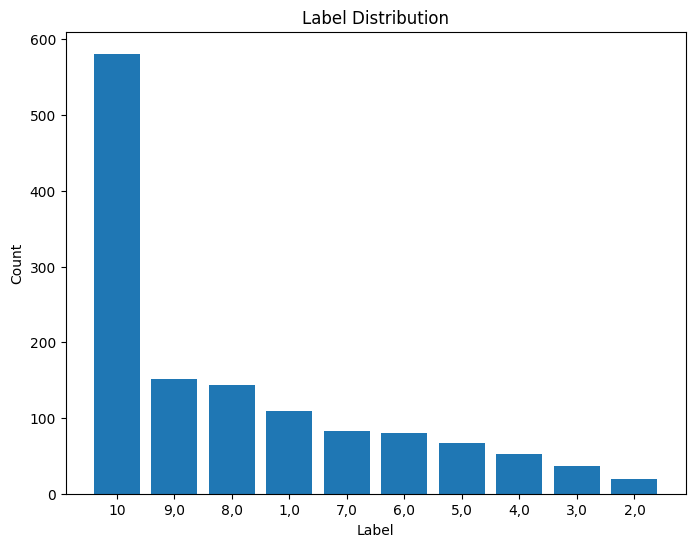

In [7]:
label_counts = dataset['Score'].value_counts()

plt.figure(figsize=(8, 6))
plt.bar(label_counts.index, label_counts)
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

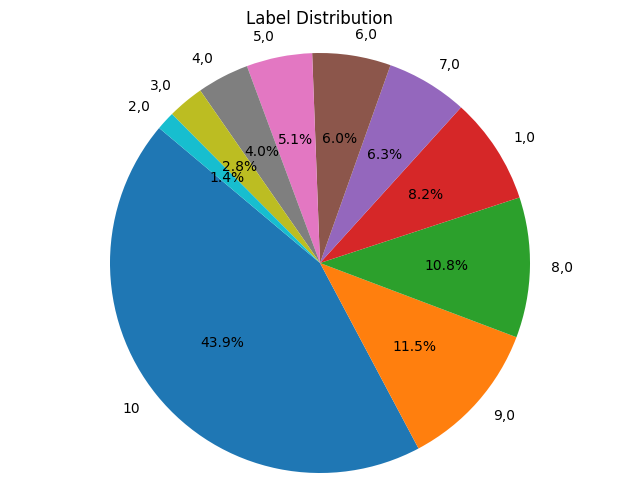

In [8]:
plt.figure(figsize=(8, 6))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Label Distribution')
plt.axis('equal')
plt.show()

# Data Cleaning

In [9]:
dataset = dataset.dropna()
dataset.shape

(1324, 2)

In [10]:
def ponctuation(phrase):
    phrase2=" "
    arabic_punctuations = '''`.‏،÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ'''
    english_punctuations = string.punctuation
    punctuations_list = arabic_punctuations + english_punctuations
    newPhrase=phrase.translate(str.maketrans(punctuations_list, ' '*len(punctuations_list)))
    newPhrase=re.sub('[0-9]',' ',phrase)
    newPhrase=re.sub('[\n,\t,\r,\n\n,\u200f]',' ',newPhrase)
    liste=newPhrase.split()
    return phrase2.join(liste)

In [11]:
def ponc_noarabic(text):
    p=" "
    COMMA            = u'\u060C'
    SEMICOLON        = u'\u061B'
    QUESTION         = u'\u061F'
    HAMZA            = u'\u0621'
    ALEF_MADDA       = u'\u0622'
    ALEF_HAMZA_ABOVE = u'\u0623'
    list1=tokenize(text, conditions=is_arabicrange, morphs=strip_tashkeel)
    unwanted_num = {COMMA,SEMICOLON,QUESTION,HAMZA,ALEF_MADDA,ALEF_HAMZA_ABOVE}
    list1 = [ele for ele in list1 if ele not in unwanted_num]
    return p.join(list1)

In [12]:
def clean_data(phrase):
    phrase2= " ";a=[]
    newPhrase=phrase.translate(str.maketrans(string.punctuation, ' '*len(string.punctuation)))
    newPhrase=re.sub('[0-9]',' ',newPhrase)
    liste=newPhrase.split()
    stops = set(stopwords.words('arabic'))
    stops={i.translate(str.maketrans("'"," ",string.punctuation)) for i in stops}
    p=["لكن","لا","لم"]
    stop=stops.difference(p)
    for i in liste:
        if i not in stop and i not in a:
            a.append(i)
    return phrase2.join(a)

In [13]:
def arabic_clean(text):
    text=ponctuation(text)
    text=ponc_noarabic(text)
    text=clean_data(text)
    return text

In [14]:
dataset['Text'] =dataset['Text'].apply(lambda x: arabic_clean(x))

In [15]:
dataset.head()

,Text,Score
0,الموظفه الاستقبال جدا رائعه سمر خاص ريم الشمري,"8,0"
1,فندق ممتاز ونظيف وموقعه ويوجد مواقف لسيارتك يت...,"9,0"
2,شكرا,"8,0"
3,المكان جميل للاقامه,"8,0"
4,جيده ومريحه نظيفه الفرش والمرتبه والوسادات مري...,"9,0"


In [16]:
dataset.shape

(1324, 2)

# Model trining

In [17]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, GRU, Bidirectional, Dense
from sklearn.model_selection import train_test_split

In [27]:
texts = dataset['Text'].tolist()
scores = dataset['Score'].tolist()

In [28]:
from sklearn.preprocessing import LabelEncoder
lb=LabelEncoder()
scores=lb.fit_transform(scores)

In [29]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
vocab_size = len(tokenizer.word_index) + 1
sequences = tokenizer.texts_to_sequences(texts)

In [30]:
max_length = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')
# scores=np.array(scores)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, scores, test_size=0.2, random_state=42)


In [32]:
def create_model(architecture):
    model = Sequential()
    model.add(Embedding(vocab_size, 100, input_length=max_length))
    if architecture == 'RNN':
        model.add(LSTM(64, dropout=0.2))
    elif architecture == 'Bidirectional_RNN':
        model.add(Bidirectional(LSTM(64, dropout=0.2)))
    elif architecture == 'GRU':
        model.add(GRU(64, dropout=0.2))
    elif architecture == 'LSTM':
        model.add(LSTM(64, dropout=0.2))
    model.add(Dense(1, activation='linear'))
    return model

In [33]:
# Train and evaluate models
architectures = ['RNN', 'Bidirectional_RNN', 'GRU', 'LSTM']
for architecture in architectures:
    model = create_model(architecture)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    print(f"Training {architecture} model...")
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=1)
    loss, mae = model.evaluate(X_test, y_test, verbose=0)
    print(f"{architecture} model - Test Loss: {loss}, Test MAE: {mae}")

Training RNN model...
Epoch 1/10
34/34 [==============================] - 10s 159ms/step - loss: 14.5241 - mae: 3.0644 - val_loss: 10.4599 - val_mae: 2.9664
Epoch 2/10
34/34 [==============================] - 3s 84ms/step - loss: 10.7421 - mae: 2.9982 - val_loss: 10.4885 - val_mae: 3.0076
Epoch 3/10
34/34 [==============================] - 2s 63ms/step - loss: 10.3710 - mae: 2.9329 - val_loss: 10.5563 - val_mae: 2.9783
Epoch 4/10
34/34 [==============================] - 1s 31ms/step - loss: 9.0504 - mae: 2.6138 - val_loss: 11.1808 - val_mae: 2.9003
Epoch 5/10
34/34 [==============================] - 1s 30ms/step - loss: 5.8013 - mae: 1.8179 - val_loss: 14.5179 - val_mae: 3.2151
Epoch 6/10
34/34 [==============================] - 1s 25ms/step - loss: 4.3973 - mae: 1.5226 - val_loss: 13.1744 - val_mae: 3.0181
Epoch 7/10
34/34 [==============================] - 1s 22ms/step - loss: 4.0313 - mae: 1.4317 - val_loss: 14.8006 - val_mae: 3.1500
Epoch 8/10
34/34 [==============================]